In [1]:
# importing basic libraries
import numpy as np
import pandas as pd

### Importing data

In [2]:
# loading the data
training = pd.read_csv("Training.csv")
test = pd.read_csv("Test.csv")
Y_training = pd.read_csv('Y_Training.csv')

In [3]:
# getting labels
y = Y_training.drop(['id'], axis=1)

print("y shape:",y.shape)

# merging training and Y_training
train = training.merge(Y_training, left_on='id', right_on='id', how='inner')

y shape: (59400, 1)


### Data exploration & understanding

In [4]:
train.head(3)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional


In [5]:
# getting some key numbers

n_status = train.shape[0]

n_feature = train.shape[1] - 1 #because of the label
 
n_nonfunctional = np.count_nonzero((train['status_group'] == 'non functional'))

n_functional = n_status - n_nonfunctional

functional_rate = n_functional/n_status*100

print('Number of pump status available:', n_status),
print('Number of features in the dataset:', n_feature)
print('Number of functional pumps:', n_functional)
print('Number of non-functional pumps:', n_nonfunctional)
print('Rate of functioning pumps:', round(functional_rate),'%')

Number of pump status available: 59400
Number of features in the dataset: 40
Number of functional pumps: 36576
Number of non-functional pumps: 22824
Rate of functioning pumps: 62 %


In [6]:
# storing and removing id
training_id = training.id
test_id = test.id
training = training.drop("id", inplace = False, axis = 1)
test = test.drop("id", inplace = False, axis = 1)

In [7]:
print("Shape of")
print("- training",training.shape)
print("- test", test.shape)
print("- train", train.shape)

Shape of
- training (59400, 39)
- test (14850, 39)
- train (59400, 41)


### Data Preparation

In [8]:
# dropping the recorded_by column because it only has 1 unique value for both Train and Test
training = training.drop(['recorded_by'], axis=1)
test = test.drop(['recorded_by'], axis=1)

In [9]:
features = pd.concat([training, test]).reset_index(drop=True)
print("features shape:", features.shape)

features shape: (74250, 38)


In [10]:
print("Overview of column types")
print('')
print(features.dtypes)

Overview of column types

amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_type              object
water_quality    

### Feature Engineering

#### Dealing with NAs

In [11]:
# chunk of code that Laurens used in the Kaggle House Prices competition
nulls = np.sum(features.isnull())
nullcols = nulls.loc[(nulls != 0)]
dtypes = features.dtypes
dtypes2 = dtypes.loc[(nulls != 0)]
info = pd.concat([nullcols, dtypes2], axis=1).sort_values(by=0, ascending=False)
print(info)
print("There are", len(nullcols), "columns with missing values.")

                       0       1
scheme_name        35258  object
scheme_management   4846  object
installer           4532  object
funder              4504  object
public_meeting      4155  object
permit              3793  object
subvillage           470  object
There are 7 columns with missing values.


In [12]:
# filling missing values with 'None' for the following features: funder, scheme_name, subvillage 
features.update(features['funder'].fillna('None'))
features.update(features['scheme_name'].fillna('None'))
features.update(features['subvillage'].fillna('None'))

In [13]:
# filling missing values with median for: public_meeting, permit 
features.update(features['public_meeting'].fillna(features['public_meeting'].median()))
features.update(features['permit'].fillna(features['permit'].median()))

In [14]:
# filling missing values with mode for: installer, scheme_management
features.update(features['installer'].fillna(features['installer'].mode()[0]))
features.update(features['scheme_management'].fillna(features['scheme_management'].mode()[0]))

#### Other transformations

In [15]:
# Replaced by MEDIAN

# year 0 in: construction_year
features['construction_year'].replace(to_replace=[0], 
                                      value = features['construction_year'].median(),
                                      inplace=True)



# Replaced by MODE

# unkown value in: payment
features['payment'].replace(to_replace=['unknown'], 
                                      value = features['payment'].mode(),
                                      inplace=True)

# unkown value in: water_quality
features['water_quality'].replace(to_replace=['unknown'], 
                                      value = features['water_quality'].mode(),
                                      inplace=True)

# unkown value in: source_class
features['source_class'].replace(to_replace=['unknown'], 
                                      value = features['source_class'].mode(),
                                      inplace=True)

# to check it worked well: list(set(features['source_class']))

#### Creating some features

In [16]:
print("Data type of date_recorded is:", features['date_recorded'].dtype)
# so we need to convert a datetime to an integer to make some features

Data type of date_recorded is: object


In [17]:
# setting date_recorded as datetime type
features['date_recorded'] = pd.to_datetime(features['date_recorded'], format='%Y-%m-%d')
print("type of 'date_recorded' :", features['date_recorded'].dtype)

# creating a feature: year_recorded
features['year_recorded'] = features['date_recorded'].dt.year

type of 'date_recorded' : datetime64[ns]


In [18]:
# time how many years the pump has been in activity at the recorded date
features['years_activity_when_rec'] = (features['year_recorded'] - features['construction_year'])

In [19]:
# I drop 'subvillage' as it has too many classes and would add mostly noise to the model
features = features.drop("subvillage", axis = 1)

#### Rescaling some numerical features

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

features_to_rescale = ['population', 'amount_tsh', 'gps_height', 'longitude', 'latitude']

for i in features_to_rescale:
    features[i] = scaler.fit_transform(features[i].values.reshape(-1,1))

C:\Users\lramp\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


#### Encoding caterical values

In [21]:
# label encoder should be preferred over One-Hot encoding, as we are going to use Random Forest for modeling
from sklearn.preprocessing import LabelEncoder

features_to_encode = ['date_recorded', 'year_recorded', 'years_activity_when_rec', 'funder', 'installer', 'wpt_name', 'basin', 'region','region_code', 'district_code','lga',
              'ward', 'public_meeting', 'scheme_management', 'scheme_name', 'permit', 'extraction_type',
              'extraction_type_group', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment',
              'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source','source_type', 'source_class',
              'waterpoint_type', 'waterpoint_type_group', 'num_private']


cols = features_to_encode
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(features[c].values)) 
    features[c] = lbl.transform(list(features[c].values))

In [22]:
# we have to split again the data between train and test

X = features.iloc[:len(train),:]
testing_features = features.iloc[len(X):,:]

print(X.shape)
print(testing_features.shape)
print("Good, both dimensions are coherent.")

(59400, 39)
(14850, 39)
Good, both dimensions are coherent.


### Modeling

In [23]:
# importing libraries
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [24]:
# cross validation
kfold = StratifiedKFold(n_splits=7, random_state=42, shuffle=True)

In [25]:
# modeling with RandomForestClassifier
rf = RandomForestClassifier()
clf = rf.fit(X, y.values.ravel()) 

In [26]:
cross_val =  cross_val_score(clf, X, y.values.ravel(), scoring='accuracy', cv = kfold)
print("Base line model: Random Forest average score:",cross_val.mean()*100)

Base line model: Random Forest average score: 79.94614344946896


### Prediction

In [27]:
prediction = rf.fit(X, y.values.ravel()).predict(testing_features)
submission = pd.DataFrame()
submission['id'] = test_id
submission['status_group'] = prediction

submission.to_csv("Pump_it_up_submission.csv",index = False)

### ROC analysis

In [28]:
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt

C:\Users\lramp\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [29]:
# multi-class classification
y = label_binarize(y, classes=['functional','non functional','functional needs repair'])

n_classes = 3

In [30]:
# shuffle and split training and test sets
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=0.25, random_state=8)

In [31]:
# Random Forest classifier
clf = OneVsRestClassifier(RandomForestClassifier())
y_score = clf.fit(X_train, y_train).predict(X_test)

In [32]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

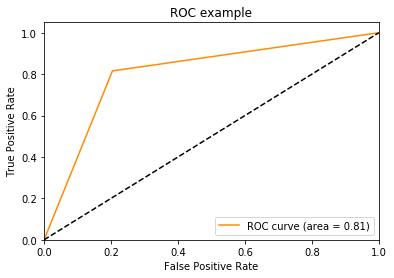

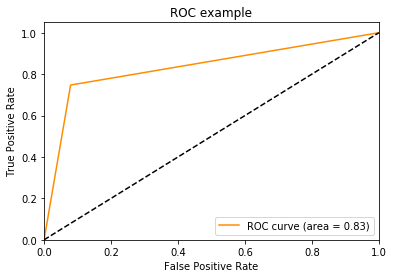

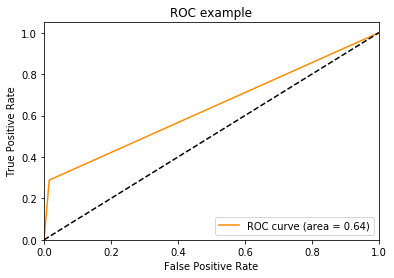

In [33]:
# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC example')
    plt.legend(loc="lower right")
    plt.show()

J'ai utilisé 75% du dataset pour le training, et donc 25% pour le test.
Il y en a 3, puisqu'il y en a 1 par label.

##### Pour les prédictions "functional"
Bon ROC, suffisamment distant de la droite de référence c'est à dire de la random measure en pointillé.
L'AUC (Area Under the Curve) est de 0.81 ce qui est convenable. 
Le ratio True Positive sur False Positive en "début de courbe" est satisfaisant (pour de la maintenance de pompes à eau...). Le modèle identifie donc bien un peu plus de 80% des pompes en état de marche, avec un bon ratio de 0.83/0.2 .

##### Pour les prédictions "non functional" 
Le ROC est également bon pour ce label, avec une AUC supérieure à 0.83.
Le True Positive Rate a un très bon ratio par rapport au False Positive Rate en "début de courbe". Cela signifie que le modèle identifie vraiment bien la majorité des True Positive. Ce ratio est vraiment bon.

##### Pour les prédictions "functional needs repair"
Mauvais ROC , faible distinction par rapport à la droite de référence.
Cela se ressent évidemment sur la AUC qui est à 0.64. Il est donc difficile de pronostiquer efficacement les pompes qui ont besoins de réparation.
Seulement 30% des True Positives sont prédits avec une quasi-certitude. C'est très faible ! Au-delà le modèle converge vers la random measure.


### What else could be done to improve the model?

- ensemble modeling
- categorizing more features (really tedious work)